## ⚙️ Importing Required Libraries
We begin by importing essential Python libraries and suppressing warnings for cleaner outputs.  
These libraries will be used for:
- **Data processing** (Pandas, NumPy)
- **Visualization** (Matplotlib, Seaborn, Plotly)
- **Machine learning** (Scikit-learn)

In [1]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

## 🛠️ Wrangling Function Definition
Defines the `wrangle()` function, which:
- Reads CSV files
- Cleans and preprocesses data
- Handles missing values
- Returns a processed DataFrame for further analysis


In [2]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    df.drop(columns=["floor","expenses"], inplace=True)

    df.drop(columns=["operation","property_type","currency","properati_url"], inplace=True)

    df.drop(columns=[
        'price',
        'price_aprox_local_currency',
        'price_per_m2',
        'price_usd_per_m2'
    ],inplace=True)
    df.drop(columns=["surface_total_in_m2","rooms"], inplace=True)
    return df

## 📂 Loading Multiple CSV Files
Uses `glob()` to identify all **Buenos Aires real estate CSV files** in the working directory.  
This ensures the script can automatically handle multiple datasets without hardcoding filenames.


In [3]:
files = glob("buenos-aires-real-estate-*.csv")
files

['buenos-aires-real-estate-1.csv',
 'buenos-aires-real-estate-2.csv',
 'buenos-aires-real-estate-3.csv',
 'buenos-aires-real-estate-4.csv',
 'buenos-aires-real-estate-5.csv']

## 🔄 Applying Data Wrangling
Applies the `wrangle()` function to each CSV file, processing them individually before combining.


In [4]:
frames = [wrangle(file) for file in files]

## 📊 Combining DataFrames
Merges all processed DataFrames into a single dataset using `pd.concat()`.  
This creates one master dataset for analysis and modeling.


In [5]:
df = pd.concat(frames,ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             6582 non-null   int64  
 1   price_aprox_usd        6582 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   lat                    6316 non-null   float64
 4   lon                    6316 non-null   float64
 5   neighborhood           6582 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 308.7+ KB
None


,Unnamed: 0,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,5,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,10,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,30,118000.0,54.0,-34.615847,-58.459957,Caballito
3,41,57000.0,42.0,-34.625222,-58.382382,Constitución
4,42,90000.0,50.0,-34.610610,-58.412511,Once


## 📈 Correlation Analysis
Calculates and inspects the correlation between numerical features and the target variable (`price_aprox_usd`).  
Helps in **feature selection** by identifying which variables have stronger relationships with housing prices.


<Axes: >

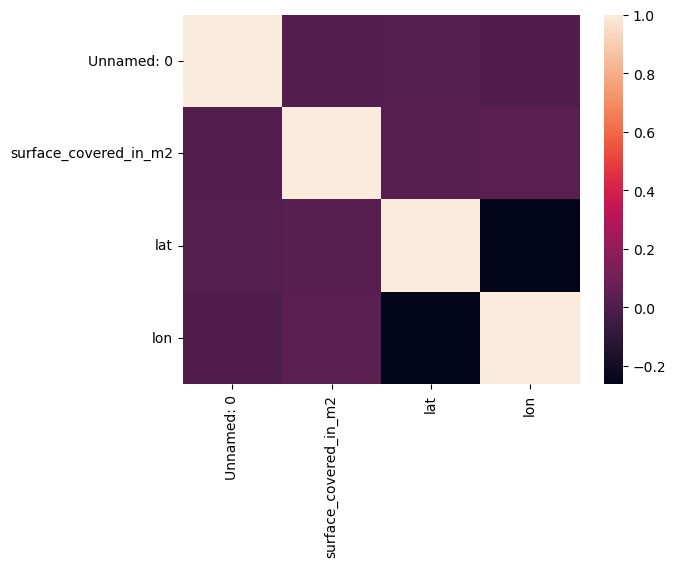

In [6]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr)

## 🎯 Defining Target Variable
Specifies the target (`y`) for prediction — `price_aprox_usd`.  
This step is crucial for supervised machine learning tasks.



In [7]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2","lat","lon","neighborhood"]
y_train = df[target]
X_train = df[features]

## 📏 Baseline Model Calculation
Computes the **baseline mean price** using training data.  
This is used to compare the performance of machine learning models.


In [8]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)

print("Mean apt price:", round(y_mean,2))

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


## 🤖 Model Creation
Builds a machine learning pipeline using:
- **Preprocessing steps** for scaling and encoding
- **Estimator** for prediction (e.g., regression model)


In [9]:
model = make_pipeline(
OneHotEncoder(use_cat_names= True),
SimpleImputer(),
Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## 📊 Model Predictions (Training Set)
Generates predictions on the training set using the trained pipeline.  
These results help evaluate **model fit** and detect potential overfitting.


In [10]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.107190330164


## 🧮 Custom Prediction Function
Defines `make_prediction()` to predict housing prices for **custom inputs** (area, latitude, longitude, neighborhood).  
This allows easy, real-time estimation for new properties.


In [11]:
def make_prediction(area, lat, lon, neighborhood):
    data={
        "surface_covered_in_m2": area,
        "lat":lat,
        "lon":lon,
        "neighborhood":neighborhood
    }
    df=pd.DataFrame(data,index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

## 🔍 Example Prediction
Uses `make_prediction()` to estimate the price of a **sample property**.  
This demonstrates how the model can be applied in real-world scenarios.


In [12]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

## 🎛️ Interactive Price Estimator
Implements an **interactive widget** with `interact()` to allow users to input property details and get instant price predictions.

In [13]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…

## ✅ Conclusion
This notebook demonstrates the complete process of:
- Cleaning and merging multiple real estate datasets
- Performing exploratory data analysis (EDA)
- Building and evaluating a machine learning model
- Creating an interactive tool for real-time price estimation

The approach provides both **data-driven insights** into Buenos Aires housing prices and a **practical application** for end-users.